# Part 4: Evaluating Retrieval-Augmented LLMs (RAG)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mekjr1/evaluating_llms_in_practice/blob/master/part-4-rag-eval/rag_eval.ipynb?hl=en#runtime_type=gpu)

This notebook demonstrates how to compute common retrieval metrics—Precision@k, Recall@k, Hit@k, Mean Reciprocal Rank (MRR), and normalized Discounted Cumulative Gain (nDCG)—on a small simulated dataset. These metrics help assess how well a retrieval system surfaces relevant documents for each query.

## Simulated Dataset

We simulate three queries with sets of relevant documents. Two models (A and B) return ranked lists of candidate documents. We compute metrics for the top **k=3** retrieved items.

In [1]:

import math
import pandas as pd

# Queries and ground-truth relevant documents
queries = ['q1', 'q2', 'q3']
relevant_docs = {
    'q1': {'doc1', 'doc3', 'doc4'},
    'q2': {'doc2', 'doc5'},
    'q3': {'doc3', 'doc6', 'doc7', 'doc9'}
}

# Retrieval results for two models
predictions_A = {
    'q1': ['doc1', 'doc2', 'doc3', 'doc4', 'doc5'],
    'q2': ['doc2', 'doc5', 'doc6', 'doc1', 'doc3'],
    'q3': ['doc4', 'doc3', 'doc7', 'doc2', 'doc8', 'doc6', 'doc9']
}

predictions_B = {
    'q1': ['doc2', 'doc4', 'doc5', 'doc1', 'doc3'],
    'q2': ['doc5', 'doc6', 'doc2', 'doc3', 'doc1'],
    'q3': ['doc9', 'doc6', 'doc7', 'doc3', 'doc8', 'doc2']
}


def precision_at_k(predicted, relevant, k):
    return sum(doc in relevant for doc in predicted[:k]) / k

def recall_at_k(predicted, relevant, k):
    return sum(doc in relevant for doc in predicted[:k]) / len(relevant)

def hit_at_k(predicted, relevant, k):
    return 1.0 if any(doc in relevant for doc in predicted[:k]) else 0.0

def mrr(predicted, relevant):
    for idx, doc in enumerate(predicted, start=1):
        if doc in relevant:
            return 1.0 / idx
    return 0.0

def dcg(predicted, relevant):
    return sum(1.0 / math.log2(i + 2) for i, doc in enumerate(predicted) if doc in relevant)

def idcg(relevant):
    return sum(1.0 / math.log2(i + 2) for i in range(len(relevant)))

def ndcg(predicted, relevant):
    denom = idcg(relevant)
    return dcg(predicted, relevant) / denom if denom > 0 else 0.0

k = 3


In [2]:

# Compute metrics for each model
models = {'Model A': predictions_A, 'Model B': predictions_B}
metrics = []
for model_name, preds in models.items():
    p_sum = r_sum = hit_sum = mrr_sum = ndcg_sum = 0
    for q in queries:
        rel = relevant_docs[q]
        res = preds[q]
        p_sum += precision_at_k(res, rel, k)
        r_sum += recall_at_k(res, rel, k)
        hit_sum += hit_at_k(res, rel, k)
        mrr_sum += mrr(res, rel)
        ndcg_sum += ndcg(res, rel)
    n = len(queries)
    metrics.append({
        'Model': model_name,
        f'Precision@{k}': round(p_sum / n, 3),
        f'Recall@{k}': round(r_sum / n, 3),
        f'Hit@{k}': round(hit_sum / n, 3),
        'MRR': round(mrr_sum / n, 3),
        'nDCG': round(ndcg_sum / n, 3)
    })

metrics_df = pd.DataFrame(metrics)
metrics_df


,Model,Precision@3,Recall@3,Hit@3,MRR,nDCG
0,Model A,0.667,0.722,1.0,0.833,0.872
1,Model B,0.667,0.694,1.0,0.833,0.866


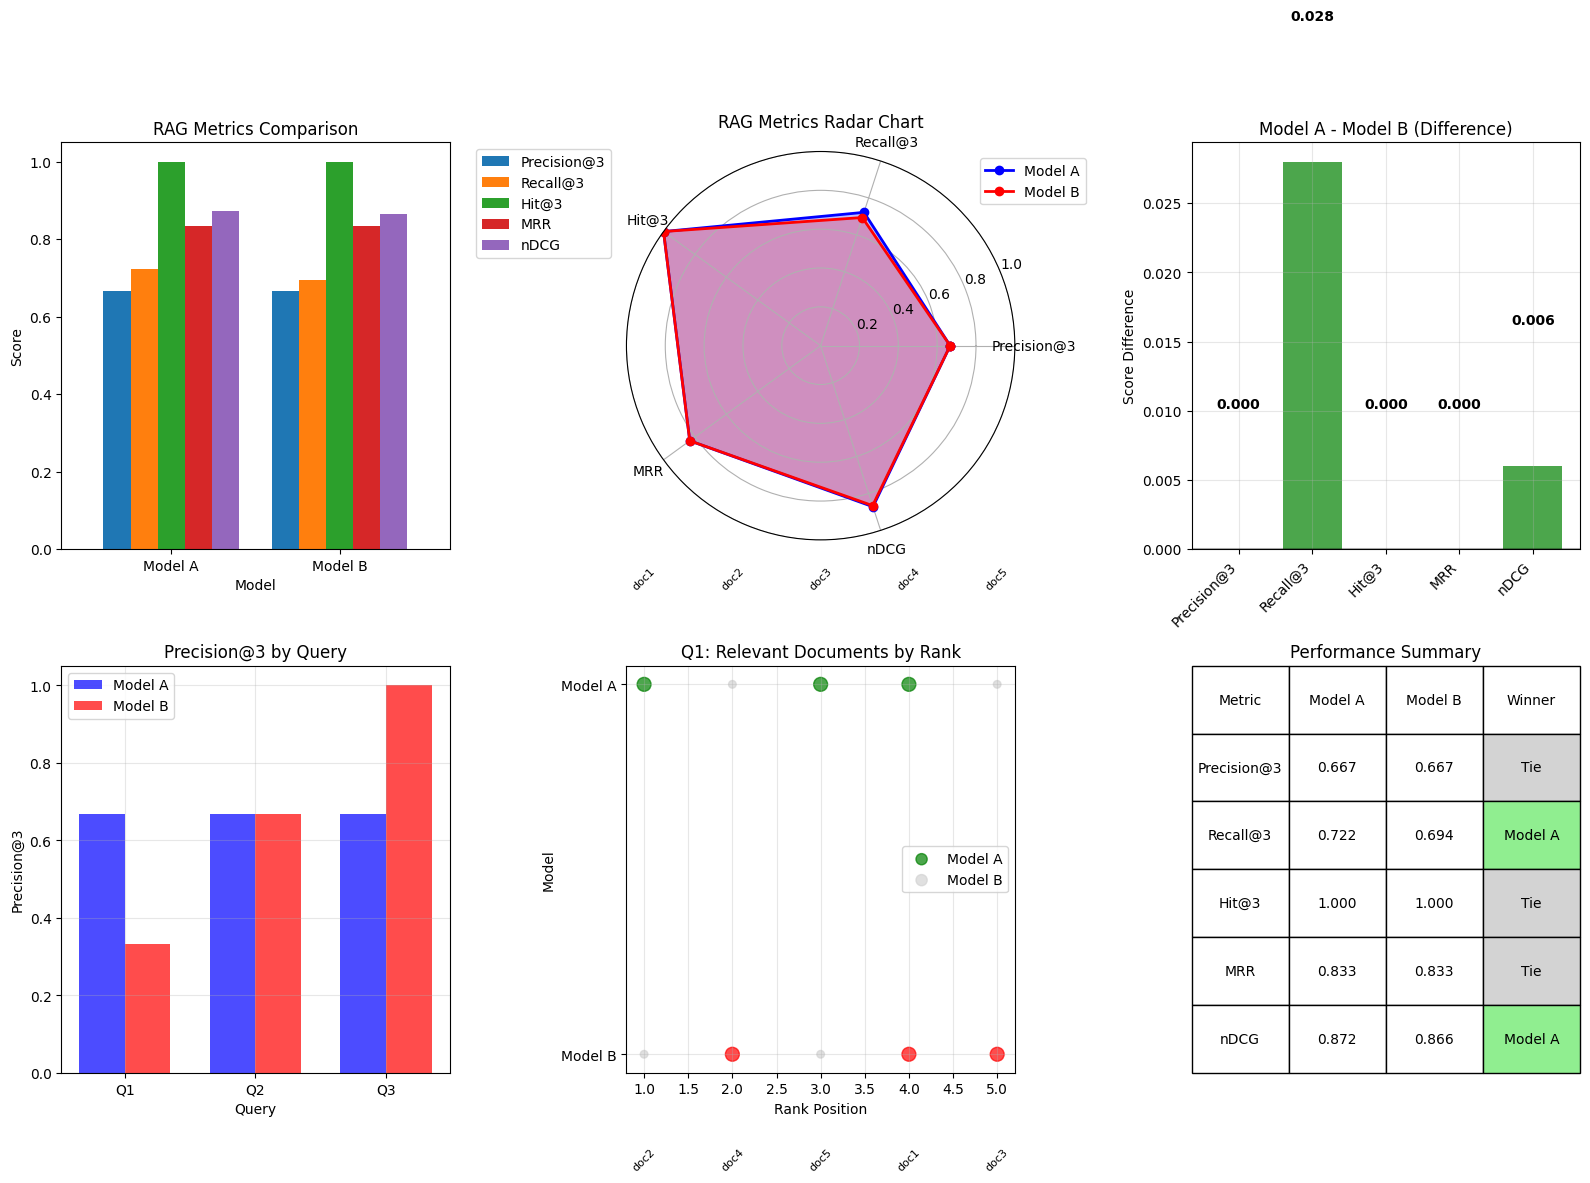

In [4]:
# Create comprehensive visualizations for RAG evaluation
import matplotlib.pyplot as plt
import numpy as np

# Create subplot layout for multiple visualizations
fig = plt.figure(figsize=(16, 12))

# 1. Bar chart comparing all metrics
ax1 = plt.subplot(2, 3, 1)
metrics_comparison = metrics_df.set_index('Model')
metrics_comparison.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('RAG Metrics Comparison')
ax1.set_ylabel('Score')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# 2. Radar chart for holistic view
ax2 = plt.subplot(2, 3, 2, projection='polar')
metrics_names = ['Precision@3', 'Recall@3', 'Hit@3', 'MRR', 'nDCG']
angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Model A
model_a_values = [0.667, 0.722, 1.0, 0.833, 0.872]
model_a_values += model_a_values[:1]  # Complete the circle
ax2.plot(angles, model_a_values, 'o-', linewidth=2, label='Model A', color='blue')
ax2.fill(angles, model_a_values, alpha=0.25, color='blue')

# Model B
model_b_values = [0.667, 0.694, 1.0, 0.833, 0.866]
model_b_values += model_b_values[:1]  # Complete the circle
ax2.plot(angles, model_b_values, 'o-', linewidth=2, label='Model B', color='red')
ax2.fill(angles, model_b_values, alpha=0.25, color='red')

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(metrics_names)
ax2.set_title('RAG Metrics Radar Chart')
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax2.set_ylim(0, 1)

# 3. Individual metric differences
ax3 = plt.subplot(2, 3, 3)
model_a_orig = [0.667, 0.722, 1.0, 0.833, 0.872]
model_b_orig = [0.667, 0.694, 1.0, 0.833, 0.866]
differences = np.array(model_a_orig) - np.array(model_b_orig)
colors = ['green' if d > 0 else 'red' if d < 0 else 'gray' for d in differences]
bars = ax3.bar(range(len(metrics_names)), differences, color=colors, alpha=0.7)
ax3.set_title('Model A - Model B (Difference)')
ax3.set_ylabel('Score Difference')
ax3.set_xticks(range(len(metrics_names)))
ax3.set_xticklabels(metrics_names, rotation=45, ha='right')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, diff) in enumerate(zip(bars, differences)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
             f'{diff:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

# 4. Query-level analysis
ax4 = plt.subplot(2, 3, 4)
query_results = []
for i, q in enumerate(queries):
    rel = relevant_docs[q]
    res_a = predictions_A[q][:k]
    res_b = predictions_B[q][:k]
    
    prec_a = precision_at_k(res_a, rel, k)
    prec_b = precision_at_k(res_b, rel, k)
    
    query_results.append({'Query': f'Q{i+1}', 'Model A': prec_a, 'Model B': prec_b})

query_df = pd.DataFrame(query_results)
x = np.arange(len(queries))
width = 0.35

ax4.bar(x - width/2, query_df['Model A'], width, label='Model A', color='blue', alpha=0.7)
ax4.bar(x + width/2, query_df['Model B'], width, label='Model B', color='red', alpha=0.7)
ax4.set_xlabel('Query')
ax4.set_ylabel('Precision@3')
ax4.set_title('Precision@3 by Query')
ax4.set_xticks(x)
ax4.set_xticklabels([f'Q{i+1}' for i in range(len(queries))])
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Ranking visualization for Query 1
ax5 = plt.subplot(2, 3, 5)
q1_relevant = relevant_docs['q1']
q1_results_a = predictions_A['q1'][:5]
q1_results_b = predictions_B['q1'][:5]

# Create ranking comparison
positions = np.arange(1, 6)
relevance_a = [1 if doc in q1_relevant else 0 for doc in q1_results_a]
relevance_b = [1 if doc in q1_relevant else 0 for doc in q1_results_b]

ax5.scatter(positions, [1]*5, s=[100 if r else 30 for r in relevance_a], 
           c=['green' if r else 'lightgray' for r in relevance_a], label='Model A', alpha=0.7)
ax5.scatter(positions, [0.8]*5, s=[100 if r else 30 for r in relevance_b], 
           c=['red' if r else 'lightgray' for r in relevance_b], label='Model B', alpha=0.7)

ax5.set_xlabel('Rank Position')
ax5.set_ylabel('Model')
ax5.set_title('Q1: Relevant Documents by Rank')
ax5.set_yticks([0.8, 1])
ax5.set_yticklabels(['Model B', 'Model A'])
ax5.legend()
ax5.grid(True, alpha=0.3)

# Add document labels
for i, (doc_a, doc_b) in enumerate(zip(q1_results_a, q1_results_b)):
    ax5.text(i+1, 1.05, doc_a, ha='center', va='bottom', fontsize=8, rotation=45)
    ax5.text(i+1, 0.75, doc_b, ha='center', va='top', fontsize=8, rotation=45)

# 6. Summary table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')

# Create summary table
summary_data = [
    ['Metric', 'Model A', 'Model B', 'Winner'],
    ['Precision@3', '0.667', '0.667', 'Tie'],
    ['Recall@3', '0.722', '0.694', 'Model A'],
    ['Hit@3', '1.000', '1.000', 'Tie'],
    ['MRR', '0.833', '0.833', 'Tie'],
    ['nDCG', '0.872', '0.866', 'Model A']
]

table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0], 
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color code the winner column
for i in range(1, len(summary_data)):
    if summary_data[i][3] == 'Model A':
        table[(i, 3)].set_facecolor('#90EE90')  # Light green
    elif summary_data[i][3] == 'Model B':
        table[(i, 3)].set_facecolor('#FFB6C1')  # Light pink
    else:
        table[(i, 3)].set_facecolor('#D3D3D3')  # Light gray

ax6.set_title('Performance Summary')

plt.tight_layout()
plt.show()

In [5]:
# Additional Analysis: Detailed breakdown by query
print("=== DETAILED QUERY ANALYSIS ===\n")

for i, q in enumerate(queries):
    print(f"Query {q.upper()}:")
    print(f"  Relevant documents: {sorted(list(relevant_docs[q]))}")
    print(f"  Model A top-{k}: {predictions_A[q][:k]}")
    print(f"  Model B top-{k}: {predictions_B[q][:k]}")
    
    # Calculate all metrics for this query
    rel = relevant_docs[q]
    res_a = predictions_A[q]
    res_b = predictions_B[q]
    
    metrics_q = {
        'Precision@3': [precision_at_k(res_a, rel, k), precision_at_k(res_b, rel, k)],
        'Recall@3': [recall_at_k(res_a, rel, k), recall_at_k(res_b, rel, k)],
        'Hit@3': [hit_at_k(res_a, rel, k), hit_at_k(res_b, rel, k)],
        'MRR': [mrr(res_a, rel), mrr(res_b, rel)],
        'nDCG': [ndcg(res_a, rel), ndcg(res_b, rel)]
    }
    
    print(f"  Metrics:")
    for metric_name, (score_a, score_b) in metrics_q.items():
        winner = "Model A" if score_a > score_b else "Model B" if score_b > score_a else "Tie"
        print(f"    {metric_name}: A={score_a:.3f}, B={score_b:.3f} → {winner}")
    print()

# Calculate and display some interesting statistics
print("=== RETRIEVAL INSIGHTS ===")

# Calculate overlap between model results
total_overlap = 0
total_positions = 0

for q in queries:
    top_a = set(predictions_A[q][:k])
    top_b = set(predictions_B[q][:k])
    overlap = len(top_a.intersection(top_b))
    total_overlap += overlap
    total_positions += k
    print(f"{q}: {overlap}/{k} documents overlap between models ({overlap/k*100:.1f}%)")

avg_overlap = total_overlap / total_positions
print(f"\nAverage overlap: {avg_overlap:.1f} ({avg_overlap*100:.1f}%)")

# Analyze ranking positions of relevant documents
print(f"\n=== RELEVANT DOCUMENT RANKINGS ===")
for q in queries:
    rel_docs = relevant_docs[q]
    print(f"\n{q.upper()} relevant documents ranking:")
    
    for model_name, preds in [("Model A", predictions_A[q]), ("Model B", predictions_B[q])]:
        positions = []
        for doc in rel_docs:
            try:
                pos = preds.index(doc) + 1  # 1-indexed
                positions.append(pos)
            except ValueError:
                positions.append("Not found")
        
        print(f"  {model_name}: {dict(zip(rel_docs, positions))}")

print(f"\n=== KEY TAKEAWAYS ===")
print(f"• Both models achieve perfect Hit@3 (find at least 1 relevant doc)")
print(f"• Model A has slightly better Recall@3 (finds more relevant docs)")  
print(f"• Model A has slightly better nDCG (better ranking quality)")
print(f"• Models have identical Precision@3 and MRR in this example")
print(f"• Average document overlap between models: {avg_overlap*100:.1f}%")

=== DETAILED QUERY ANALYSIS ===

Query Q1:
  Relevant documents: ['doc1', 'doc3', 'doc4']
  Model A top-3: ['doc1', 'doc2', 'doc3']
  Model B top-3: ['doc2', 'doc4', 'doc5']
  Metrics:
    Precision@3: A=0.667, B=0.333 → Model A
    Recall@3: A=0.667, B=0.333 → Model A
    Hit@3: A=1.000, B=1.000 → Tie
    MRR: A=1.000, B=0.500 → Model A
    nDCG: A=0.906, B=0.680 → Model A

Query Q2:
  Relevant documents: ['doc2', 'doc5']
  Model A top-3: ['doc2', 'doc5', 'doc6']
  Model B top-3: ['doc5', 'doc6', 'doc2']
  Metrics:
    Precision@3: A=0.667, B=0.667 → Tie
    Recall@3: A=1.000, B=1.000 → Tie
    Hit@3: A=1.000, B=1.000 → Tie
    MRR: A=1.000, B=1.000 → Tie
    nDCG: A=1.000, B=0.920 → Model A

Query Q3:
  Relevant documents: ['doc3', 'doc6', 'doc7', 'doc9']
  Model A top-3: ['doc4', 'doc3', 'doc7']
  Model B top-3: ['doc9', 'doc6', 'doc7']
  Metrics:
    Precision@3: A=0.667, B=1.000 → Model B
    Recall@3: A=0.500, B=0.750 → Model B
    Hit@3: A=1.000, B=1.000 → Tie
    MRR: A=0.500, 

### Discussion

* **Precision@k** measures the fraction of the top-k retrieved documents that are relevant.
* **Recall@k** measures the fraction of relevant documents that appear in the top-k.
* **Hit@k** is a binary metric indicating whether any relevant documents are retrieved in the top-k.
* **MRR** (mean reciprocal rank) rewards retrieving a relevant document early in the ranking.
* **nDCG** accounts for the position of all relevant documents, giving higher weight to those at the top.

In this simulation, both models retrieve at least one relevant document in the top 3 for every query, but **Model A** has slightly higher recall and nDCG than **Model B**.

---

This notebook is part of a series on evaluating LLMs. You can find the accompanying blog post and other notebooks in the repository.